# **04 — Modeling and Evaluation**

# 1. Objective
The objective of this notebook is to train, evaluate, and interpret predictive classification models that estimate the probability of a client subscribing to a term deposit.

This stage focuses on:

* Selecting an appropriate baseline model
* Handling class imbalance during training
* Evaluating model performance using business-relevant metrics
* Interpreting results and identifying key predictive drivers
* Translating model performance into business implications

# 2. Dataset and Feature Artifacts

In [12]:
import pandas as pd
import numpy as np

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve
)

import matplotlib.pyplot as plt


In [13]:
# Reload dataset and rebuild engineered features
# (kept explicit for notebook independence)

df = pd.read_csv(
    "data/bank-additional-full.csv",
    sep=";"
)

# Target encoding
df['y_binary'] = df['y'].map({'no': 0, 'yes': 1})

# Remove leakage-prone and target columns
df_model = df.drop(columns=['y', 'duration'])

# One-Hot Encoding
categorical_features = df_model.select_dtypes(include=['object']).columns
df_encoded = pd.get_dummies(
    df_model,
    columns=categorical_features,
    drop_first=True
)

# Feature matrix and target
X = df_encoded.drop(columns=['y_binary'])
y = df_encoded['y_binary']

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)


# 3. Model Selection Rationale
A Random Forest Classifier is selected as the primary model due to:

* Its ability to capture non-linear relationships
* Robust performance on mixed numerical and categorical features
* Minimal feature scaling requirements
* Built-in support for class weighting
* Interpretability via feature importance

Given the strong class imbalance (~11% positive class), class weights are adjusted to penalize false negatives.

# 4. Model Training

In [14]:
rf_model = RandomForestClassifier(
    n_estimators=200,
    random_state=42,
    class_weight='balanced',
    n_jobs=-1
)

rf_model.fit(X_train, y_train)


RandomForestClassifier(class_weight='balanced', n_estimators=200, n_jobs=-1,
                       random_state=42)

# 5. Model Evaluation

## 5.1 Predictions and Probabilities

In [15]:
y_pred = rf_model.predict(X_test)
y_prob = rf_model.predict_proba(X_test)[:, 1]


## 5.2 Confusion Matrix

In [16]:
cm = confusion_matrix(y_test, y_pred)
cm


array([[7109,  201],
       [ 665,  263]])

Interpretation

* True Positives represent successfully identified potential subscribers.
* False Negatives are costly missed opportunities.
* False Positives increase call volume but are less costly than missed subscribers.

## 5.3 Classification Report

In [17]:
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.91      0.97      0.94      7310
           1       0.57      0.28      0.38       928

    accuracy                           0.89      8238
   macro avg       0.74      0.63      0.66      8238
weighted avg       0.88      0.89      0.88      8238



Key Metrics of Interest

* Recall (yes): ability to capture potential subscribers
* Precision (yes): efficiency of targeting
* F1-score: balance between recall and precision

Accuracy is reported but not considered a primary metric due to class imbalance.

## 5.4 ROC AUC

In [18]:
roc_auc = roc_auc_score(y_test, y_prob)
roc_auc


np.float64(0.7795619044530403)

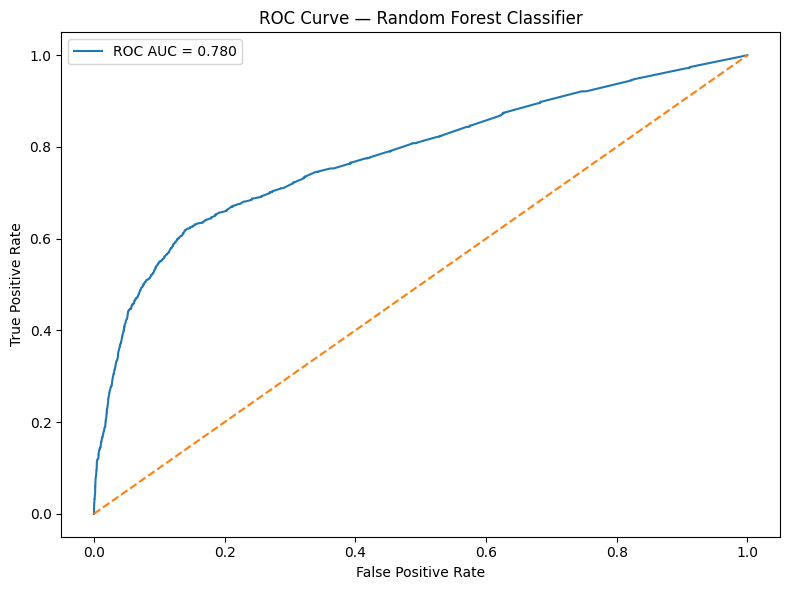

In [19]:
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC AUC = {roc_auc:.3f}")
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve — Random Forest Classifier")
plt.legend()
plt.tight_layout()
plt.show()


*Interpretation*

* ROC AUC provides a threshold-independent evaluation.
* Values significantly above 0.5 indicate strong discriminative power

# 6. Feature Importance Analysis

In [20]:
feature_importance = pd.Series(
    rf_model.feature_importances_,
    index=X.columns
).sort_values(ascending=False)

feature_importance.head(15)


,0
age,0.152423
euribor3m,0.134853
campaign,0.082600
nr.employed,0.057461
emp.var.rate,0.051260
housing_yes,0.034190
cons.conf.idx,0.033587
cons.price.idx,0.022595
loan_yes,0.022444
pdays,0.021009


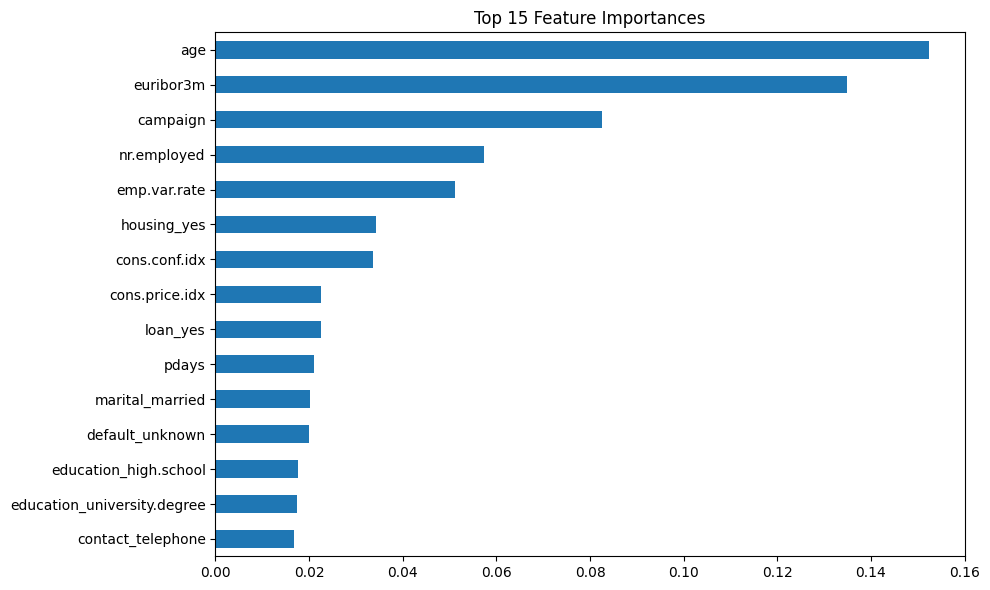

In [21]:
plt.figure(figsize=(10, 6))
feature_importance.head(15).plot(kind='barh')
plt.title("Top 15 Feature Importances")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


*Key Insight*

* Historical campaign outcomes (poutcome_success, previous) are strong predictors.
* Macroeconomic indicators also play a significant role.
* Features related to contact frequency (campaign) negatively impact conversion.

# 7. Business Interpretation

From a business perspective, the model enables:

* Prioritization of high-probability clients
* Reduction in unnecessary call volume
* Better allocation of marketing resources
* Increased conversion rates without increasing campaign size

The model is particularly effective at identifying clients with a history of positive engagement, aligning with observed EDA patterns.

# 8. Limitations

* The model does not account for temporal effects explicitly.
* Call duration was excluded due to data leakage, limiting maximum achievable performance.
* The dataset reflects historical behavior (2008–2010), which may not fully generalize to current markets.

# 9. Next Steps and Improvements

Potential future enhancements include:

* Threshold optimization based on business cost functions
* Gradient Boosting or XGBoost comparison
* Time-aware validation strategies
* Cost-sensitive learning
* Deployment as a lead-scoring system

# 10. Final Conclusion

This project demonstrates an end-to-end predictive analytics workflow:

* Clear business framing
* Structured data preparation
* Thoughtful model selection
* Proper evaluation under class imbalance
* Actionable business insights
* The resulting model provides a strong foundation for data-driven decision-making in marketing campaign optimization.